# Project 02 - Image Processing

## Student Information

- Full name: Bùi Minh Duy
- Student ID: 23127040
- Class: 23CLC01

## Required Libraries

In [1]:
# IMPORT YOUR LIBS HERE
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


## Function Definitions

In [2]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image
    '''

    # YOUR CODE HERE
    img = Image.open(img_path).convert('RGB')
    img_array = np.array(img)
    return img_array


def show_img(img):
    '''
    Show image

    Parameters
    ----------
    img : <your type>
        Image
    '''

    # YOUR CODE HERE
    img_display = np.clip(img, 0, 255).astype(np.uint8)
    plt.imshow(img_display)
    plt.axis('off')
    plt.show()


def save_img(img, img_path, suffix):
    '''
    Save image to img_path

    Parameters
    ----------
    img : <your type>
        Image
    img_path : str
        Path of image
    suffix : str
        Suffix of image file (e.g., "blur")
    '''

    # YOUR CODE HERE
    name, ext = img_path.rsplit('.', 1)
    ext = ext.lower()

    if ext not in ['png', 'jpg', 'jpeg']:
        print("Unsupported file type.")
        return

    new_path = f"{name}_{suffix}.{ext}"
    img = Image.fromarray(np.clip(img, 0, 255).astype(np.uint8))
    img.save(new_path)


#--------------------------------------------------------------------------------
# YOUR FUNCTIONS HERE
def adjust_brightness(img_array, value):
    """
    Adjusts the brightness of the image.

    Parameters:
        img_array (np.ndarray): Input RGB image.
        value (int or float): Brightness adjustment value (positive or negative).

    Returns:
        np.ndarray: Brightness-adjusted image.
    """
    img = img_array.astype(np.float32)
    img += value
    return np.clip(img, 0, 255).astype(np.uint8)


def adjust_contrast(img_array, alpha):
    """
    Adjusts the contrast of the image using the actual mean intensity.

    Parameters:
        img_array (np.ndarray): Input RGB image.
        alpha (float): Contrast factor (>1 to increase contrast, <1 to decrease).

    Returns:
        np.ndarray: Contrast-adjusted image.
    """
    img = img_array.astype(np.float32)
    mean = np.mean(img)
    img = mean + alpha * (img - mean)
    return np.clip(img, 0, 255).astype(np.uint8)


def flip_image(img_array, direction):
    """
    Flips the image horizontally or vertically.

    Parameters:
        img_array (np.ndarray): Input RGB image.
        direction (str): 'horizontal' or 'vertical'.

    Returns:
        np.ndarray: Flipped image.
    """
    return np.flip(img_array, axis=1 if direction == 'horizontal' else 0)


def rgb_to_grayscale(img_array):
    """
    Converts an RGB image to grayscale using standard luminance weights.

    Parameters:
        img_array (np.ndarray): Input RGB image.

    Returns:
        np.ndarray: Grayscale image with 3 identical channels.
    """
    img = img_array.astype(np.float32)
    gray = 0.299 * img[...,0] + 0.587 * img[...,1] + 0.114 * img[...,2]
    gray = np.stack([gray]*3, axis=-1)
    return np.clip(gray, 0, 255).astype(np.uint8)


def rgb_to_sepia(img_array):
    """
    Applies a sepia tone effect to the RGB image.

    Parameters:
        img_array (np.ndarray): Input RGB image.

    Returns:
        np.ndarray: Sepia-toned image.
    """
    img = img_array.astype(np.float32)
    sepia_filter = np.array([[0.393, 0.769, 0.189],
                             [0.349, 0.686, 0.168],
                             [0.272, 0.534, 0.131]])
    sepia = img @ sepia_filter.T
    return np.clip(sepia, 0, 255).astype(np.uint8)


def apply_filter(img_array, kernel):
    """
    Applies a fixed convolution filter to the image.
    Only supports 'blur' (Gaussian 3x3) or 'sharpen' filters.

    Parameters:
        img_array (np.ndarray): Input RGB image.
        kernel (str): Filter type: 'blur' or 'sharpen'.

    Returns:
        np.ndarray: Filtered image.
    """
    img = img_array.astype(np.float32)

    if kernel == 'blur':
        kernel_matrix = np.ones((5, 5), dtype=np.float32) / 25
    elif kernel == 'sharpen':
        kernel_matrix = np.array([
            [ 0, -1,  0],
            [-1,  5, -1],
            [ 0, -1,  0]
        ], dtype=np.float32)
    else:
        raise ValueError("Invalid kernel type. Use 'blur' or 'sharpen'.")

    kh, kw = kernel_matrix.shape
    pad_h, pad_w = kh // 2, kw // 2
    h, w, c = img.shape
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='edge')
    result = np.zeros_like(img)

    for i in range(h):
        for j in range(w):
            for k in range(c):
                region = padded[i:i+kh, j:j+kw, k]
                result[i, j, k] = np.sum(region * kernel_matrix)

    return np.clip(result, 0, 255).astype(np.uint8)


def center_crop(img_array, new_size):
    """
    Crops a square image from the center with given size.

    Parameters:
        img_array (np.ndarray): Input square RGB image.
        new_size (int): The size (height and width) of the cropped image.

    Returns:
        np.ndarray: Center-cropped image.
    """
    h, w = img_array.shape[:2]
    start = (h - new_size) // 2
    return img_array[start:start+new_size, start:start+new_size]


def circular_crop(img_array):
    """
    Applies a circular crop to a square image. Pixels outside the circle are set to black.

    Parameters:
        img_array (np.ndarray): Input square RGB image.

    Returns:
        np.ndarray: Circularly cropped image.
    """
    h, w = img_array.shape[:2]
    Y, X = np.ogrid[:h, :w]
    center = h // 2
    radius = h // 2
    mask = (X - center) ** 2 + (Y - center) ** 2 <= radius ** 2

    output = np.zeros_like(img_array)
    output[mask] = img_array[mask]
    return output


def double_ellipse_crop(img_array, ratio):
    """
    Applies a mask that keeps only the union of two ellipses rotated at ±45°,
    both ellipses inscribed in the square image. The shape of the ellipses is
    controlled by the ratio (b / a), where a is the semi-major axis and b is the semi-minor axis.

    Parameters:
        img_array (np.ndarray): Input square image as NumPy array.
        ratio (float): Ratio b/a between semi-minor and semi-major axes. Must be in (0, 1).

    Returns:
        np.ndarray: Image masked with the union of the two ellipses.
    """
    h, w = img_array.shape[:2]

    Y, X = np.ogrid[:h, :w]
    cx, cy = w // 2, h // 2

    a = h / (np.sqrt(2 * (1 + ratio**2)))    
    b = a * ratio  

    theta1 = np.deg2rad(45)
    x_rot1 = (X - cx) * np.cos(theta1) + (Y - cy) * np.sin(theta1)
    y_rot1 = -(X - cx) * np.sin(theta1) + (Y - cy) * np.cos(theta1)
    mask1 = (x_rot1 / a)**2 + (y_rot1 / b)**2 <= 1

    theta2 = np.deg2rad(-45)
    x_rot2 = (X - cx) * np.cos(theta2) + (Y - cy) * np.sin(theta2)
    y_rot2 = -(X - cx) * np.sin(theta2) + (Y - cy) * np.cos(theta2)
    mask2 = (x_rot2 / a)**2 + (y_rot2 / b)**2 <= 1

    mask = mask1 | mask2

    output = np.zeros_like(img_array)
    output[mask] = img_array[mask]
    return output



<ins>Note:</ins> For clarity, include docstrings with each function.

## Your tests

In [3]:
# YOUR CODE HERE
import time

def benchmark(img_path):
    try:
        img_array = read_img(img_path)
    except:
        print("Không đọc được ảnh.")
        return

    # 1. Brightness
    start = time.time()
    bright = adjust_brightness(img_array, 40)
    end = time.time()
    save_img(bright, img_path, "bright")
    print(f"→ adjust_brightness: {end - start:.4f} giây")

    # 2. Contrast
    start = time.time()
    contrast = adjust_contrast(img_array, 1.5)
    end = time.time()
    save_img(contrast, img_path, "contrast")
    print(f"→ adjust_contrast: {end - start:.4f} giây")

    # 3. Flip horizontal
    start = time.time()
    flip_h = flip_image(img_array, 'horizontal')
    end = time.time()
    save_img(flip_h, img_path, "flip_horizontal")
    print(f"→ flip_horizontal: {end - start:.4f} giây")

    # 4. Flip vertical
    start = time.time()
    flip_v = flip_image(img_array, 'vertical')
    end = time.time()
    save_img(flip_v, img_path, "flip_vertical")
    print(f"→ flip_vertical: {end - start:.4f} giây")

    # 5. Grayscale
    start = time.time()
    gray = rgb_to_grayscale(img_array)
    end = time.time()
    save_img(gray, img_path, "gray")
    print(f"→ grayscale: {end - start:.4f} giây")

    # 6. Sepia
    start = time.time()
    sepia = rgb_to_sepia(img_array)
    end = time.time()
    save_img(sepia, img_path, "sepia")
    print(f"→ sepia: {end - start:.4f} giây")

    # 7. Blur
    start = time.time()
    blur = apply_filter(img_array, kernel='blur')
    end = time.time()
    save_img(blur, img_path, "blur")
    print(f"→ blur: {end - start:.4f} giây")

    # 8. Sharpen
    start = time.time()
    sharpen = apply_filter(img_array, kernel='sharpen')
    end = time.time()
    save_img(sharpen, img_path, "sharpen")
    print(f"→ sharpen: {end - start:.4f} giây")

    # 9. Center crop
    start = time.time()
    crop = center_crop(img_array, 256)
    end = time.time()
    save_img(crop, img_path, "crop_center")
    print(f"→ center_crop: {end - start:.4f} giây")

    # 10. Circle crop
    start = time.time()
    circle = circular_crop(img_array)
    end = time.time()
    save_img(circle, img_path, "crop_circle")
    print(f"→ circular_crop: {end - start:.4f} giây")

    # 11. Double ellipse crop
    start = time.time()
    ellipse = double_ellipse_crop(img_array, 0.6)
    end = time.time()
    save_img(ellipse, img_path, "crop_ellipse")
    print(f"→ double_ellipse_crop: {end - start:.4f} giây")

img_path = input("Nhập tên ảnh (vd: cat.png): ")
benchmark(img_path)


→ adjust_brightness: 0.0018 giây
→ adjust_contrast: 0.0044 giây
→ flip_horizontal: 0.0000 giây
→ flip_vertical: 0.0000 giây
→ grayscale: 0.0043 giây
→ sepia: 0.0075 giây
→ blur: 2.7607 giây
→ sharpen: 2.6351 giây
→ center_crop: 0.0000 giây
→ circular_crop: 0.0069 giây
→ double_ellipse_crop: 0.0150 giây


## Main FUNCTION

In [4]:
# YOUR CODE HERE
def main():
    img_path = input("Nhập tên file ảnh (vd: cat.png): ")
    try:
        img_array = read_img(img_path)
    except:
        print("Không tìm thấy ảnh.")
        return

    print("Chọn chức năng:")
    print("""
    0. Tất cả
    1. Thay đổi độ sáng
    2. Thay đổi độ tương phản
    3. Lật ảnh (ngang - dọc)
    4. Chuyển đổi ảnh RGB thành ảnh Xám/Sepia
    5. Làm mờ/Sắc nét
    6. Cắt ảnh theo kích thước (cắt ở trung tâm)
    7. Cắt ảnh theo khung hình tròn
    8. Cắt ảnh theo khung 2 hình elip chéo nhau
    9. Thoát
    """)

    while True:
        try:
            choice = int(input("Nhập lựa chọn (0-9): "))
            if 0 <= choice <= 8:
                break
            elif choice == 9:               
                return
            else:
                print("Vui lòng nhập số nguyên từ 0 đến 9.")
        except ValueError:
            print("Giá trị không hợp lệ. Vui lòng nhập số nguyên.")

    print("Ảnh gốc:")
    show_img(img_array)

    if choice == 0 or choice == 1:
        value = float(input("Nhập giá trị thay đổi độ sáng (v < 0 để giảm, v > 0 để tăng): "))
        result = adjust_brightness(img_array, value)
        save_img(result, img_path, "bright")
        print("Thay đổi độ sáng:")
        show_img(result)

    if choice == 0 or choice == 2:
        while True:
            try:
                alpha = float(input("Nhập hệ số tương phản (0 < a < 1 để giảm, a > 1 để tăng): "))
                if alpha > 0:
                    break
                else:
                    print("Hệ số alpha phải lớn hơn 0.")
            except ValueError:
                print("Giá trị không hợp lệ. Vui lòng nhập một số thực dương.")

        result = adjust_contrast(img_array, alpha)
        save_img(result, img_path, "contrast")
        print("Thay đổi độ tương phản:")
        show_img(result)

    if choice == 0 or choice == 3:
        while True:
            mode = input("Lật ngang (h) hay dọc (v)? ")
            if mode in ['h', 'v']:
                break
            else:
                print("Lựa chọn không hợp lệ. Vui lòng nhập 'h' hoặc 'v'.")

        if mode == 'h':
            result = flip_image(img_array, 'horizontal')
            save_img(result, img_path, "flip_horizontal")
            print("Lật ảnh ngang:")
            show_img(result)
        elif mode == 'v':
            result = flip_image(img_array, 'vertical')
            save_img(result, img_path, "flip_vertical")
            print("Lật ảnh dọc:")
            show_img(result)
        else:
            print("Lựa chọn không hợp lệ.")

    if choice == 0 or choice == 4:
        gray = rgb_to_grayscale(img_array)
        sepia = rgb_to_sepia(img_array)
        save_img(gray, img_path, "gray")
        save_img(sepia, img_path, "sepia")
        print("Ảnh xám:")
        show_img(gray)
        print("Ảnh sepia:")
        show_img(sepia)

    if choice == 0 or choice == 5:
        blurred = apply_filter(img_array, kernel='blur')
        sharpened = apply_filter(img_array, kernel='sharpen')
        save_img(blurred, img_path, "blur")
        save_img(sharpened, img_path, "sharpen")
        print("Làm mờ:")
        show_img(blurred)
        print("Làm sắc nét:")
        show_img(sharpened)

    if choice == 0 or choice == 6:
        h, w = img_array.shape[:2]  
        while True:
            try:
                size = int(input(f"Nhập kích thước ảnh cần cắt (0 < s < {h}): "))
                if 0 < size < h:
                    break
                else:
                    print(f"Giá trị không hợp lệ. Kích thước phải trong khoảng (0, {h})")
            except ValueError:
                print(" Vui lòng nhập một số nguyên hợp lệ.")

        result = center_crop(img_array, size)
        save_img(result, img_path, "crop_center")
        print("Cắt ảnh theo khung hình vuông ở trung tâm:")
        show_img(result)

    if choice == 0 or choice == 7:
        circle = circular_crop(img_array)
        save_img(circle, img_path, "crop_circle")
        print("Cắt ảnh theo khung hình tròn:")
        show_img(circle)

    if choice == 0 or choice == 8:
        while True:
            try:
                ratio = float(input("Nhập tỉ lệ giữa bán kính nhỏ và lớn (0 < r < 1): "))
                if 0 < ratio < 1:
                    break
                else:
                    print("Giá trị r phải nằm trong khoảng (0, 1).")
            except ValueError:
                print("Vui lòng nhập một số thực hợp lệ.")

        ellipse = double_ellipse_crop(img_array, ratio)
        save_img(ellipse, img_path, "crop_ellipse")
        print("Cắt ảnh theo khung 2 hình elip chéo nhau:")
        show_img(ellipse)


Chọn chức năng:

    0. Tất cả
    1. Thay đổi độ sáng
    2. Thay đổi độ tương phản
    3. Lật ảnh (ngang - dọc)
    4. Chuyển đổi ảnh RGB thành ảnh Xám/Sepia
    5. Làm mờ/Sắc nét
    6. Cắt ảnh theo kích thước (cắt ở trung tâm)
    7. Cắt ảnh theo khung hình tròn
    8. Cắt ảnh theo khung 2 hình elip chéo nhau
    9. Thoát
    
Ảnh gốc:


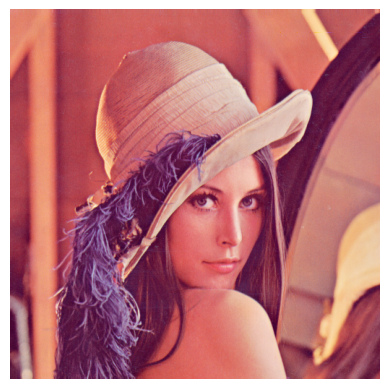

Thay đổi độ sáng:


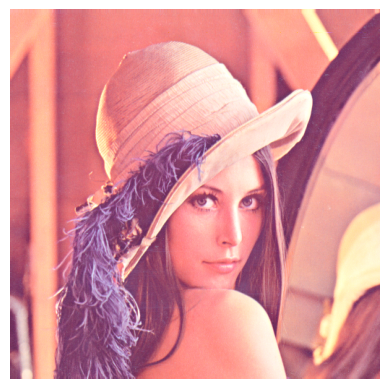

Thay đổi độ tương phản:


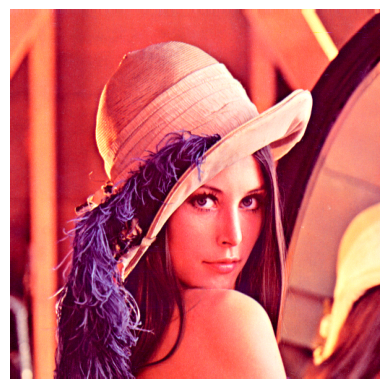

Lật ảnh ngang:


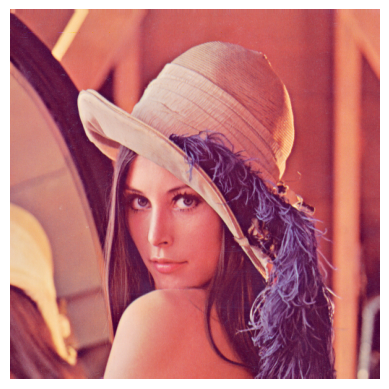

Ảnh xám:


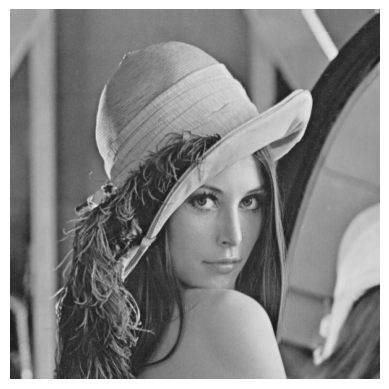

Ảnh sepia:


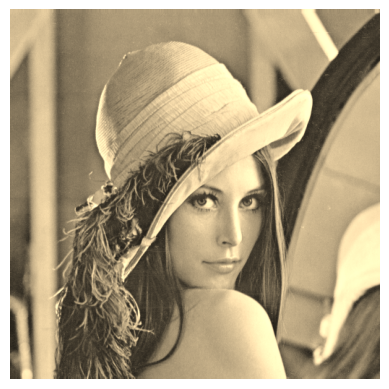

Làm mờ:


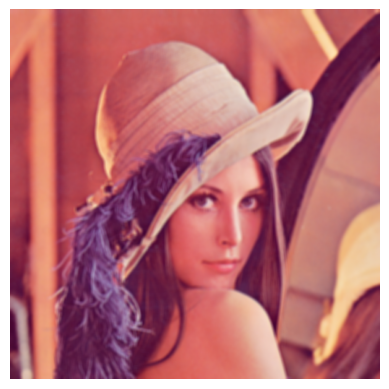

Làm sắc nét:


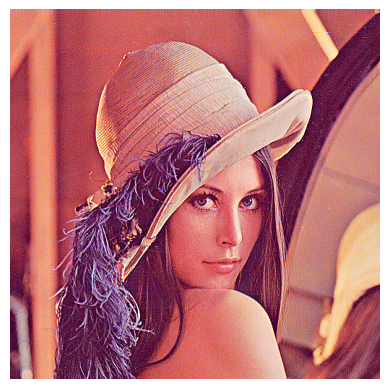

Cắt ảnh theo khung hình vuông ở trung tâm:


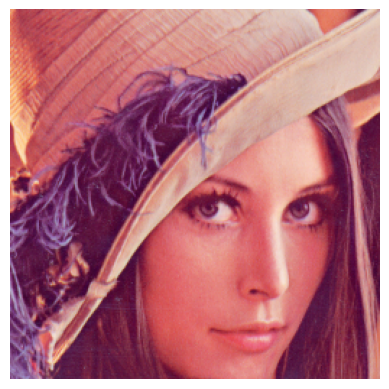

Cắt ảnh theo khung hình tròn:


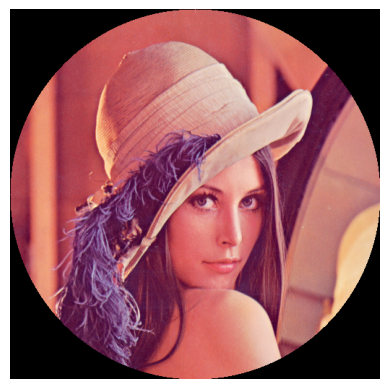

Cắt ảnh theo khung 2 hình elip chéo nhau:


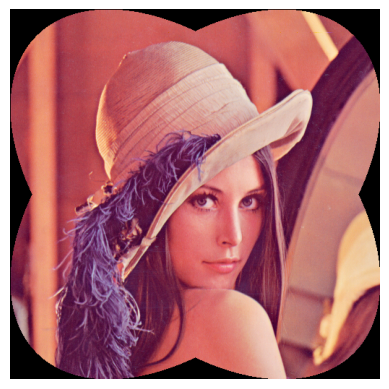

In [7]:
# Call main function
if __name__ == "__main__":
    main()
